## Imports

In [3]:
import sys
import os

current_dir = os.getcwd() 
sys.path.append(os.path.join(current_dir, '..'))

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# Traffic Signal Controller Reinforcement Learning Modules
from tscRL.environments.environment import SumoEnvironment, TrafficLight as tl
from tscRL.agents import ql_agent, fixedTL_agent as ftl_agent

# Include sumo-tools directory
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
    



## Parameter Exploration

### Epsilon Greedy Policy

#### Estrategias para decaer Epsilon en Epsilon-Greedy 

In [4]:
# Exponencial
def calculate_exp_epsilon(decayRate, steps, startEpsilon=1.0, endEpsilon=0.001):
    x = np.arange(steps)
    y = endEpsilon + (startEpsilon - endEpsilon) * np.exp(-decayRate * x)
    return x, y

# Lineal
def calculate_linear_epsilon(steps, startEpsilon=1.0, endEpsilon=0.001):
    slope = (startEpsilon - endEpsilon) / steps
    x = np.arange(steps)
    y = startEpsilon - slope * x
    y = np.maximum(y, endEpsilon)  # Asegura que el valor mínimo sea endEpsilon
    return x, y

#### Decay rates
Rasa con la que decae epsilon a través de los pasos de tiempo (steps)

In [5]:
decay_rates = [0.01, 0.02, 0.025, 0.03, 0.05]

#### Análisis de funciones epsilon a través del tiempo

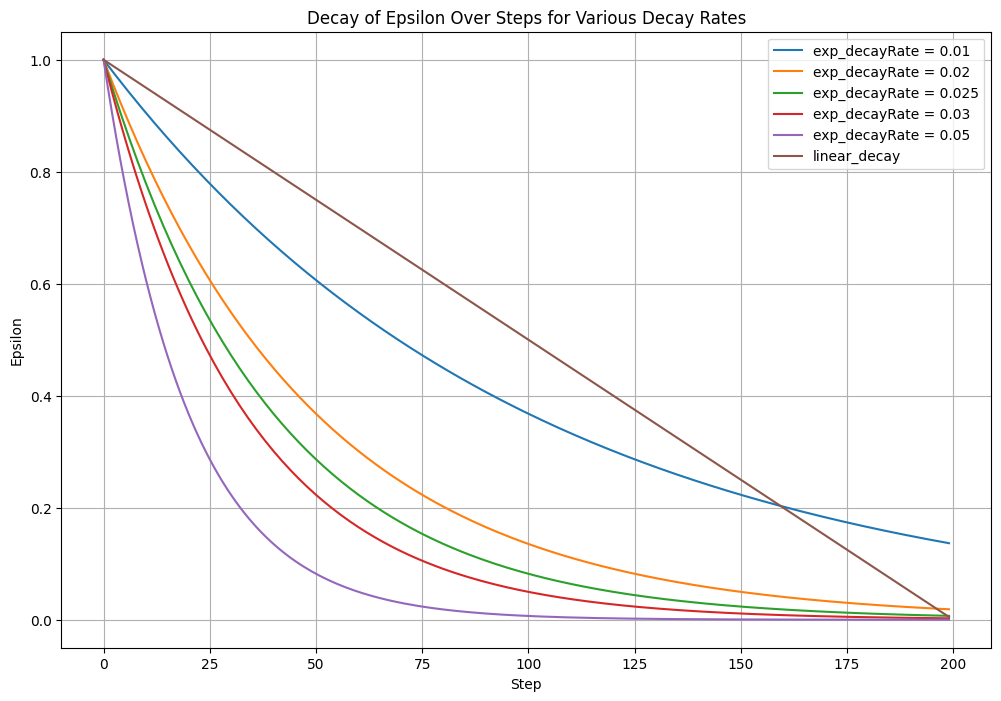

In [6]:
episodes = 200

endEpsilon = 0.01
startEpsilon = 1

plt.figure(figsize=(12, 8))

for decayRate in decay_rates:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')

x, y = calculate_linear_epsilon(episodes)
plt.plot(x, y, label=f'linear_decay')

plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
decay_rates = [0.02, 0.03]

In [84]:
start_epsilons = [1, 0.8]

### Q-Learning - Parámetros

#### Delta time
Tiempo de simulación (en segundos) entre pasos (steps)

In [8]:
delta_times = [5]

#### Phases
Posibles fases de un semáforo. Determina el espacio de acción (action space)

In [9]:
phases = [{'init':   tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'ns_sn_l':   tl.Phase("GGGgrrrrGGGgrrrr", "yyyyrrrryyyyrrrr"), #
        'ew_we_l':   tl.Phase("rrrrGGGgrrrrGGGg", "rrrryyyyrrrryyyy"), #
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),
        'sn':        tl.Phase("rrrrrrrrGGGGrrrr", "rrrrrrrryyyyrrrr"),
        'ns':        tl.Phase("GGGGrrrrrrrrrrrr", "yyyyrrrrrrrrrrrr"),
        'we':        tl.Phase("rrrrrrrrrrrrGGGG", "rrrrrrrrrrrryyyy"),
        'ew':        tl.Phase("rrrrGGGGrrrrrrrr", "rrrryyyyrrrrrrrr"),
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),  # 4 phases
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),  #
        'ne_sw':     tl.Phase("rrrGrrrrrrrGrrrr", "rrryrrrrrrryrrrr"),  #
        'wn_es':     tl.Phase("rrrrrrrGrrrrrrrG", "rrrrrrryrrrrrrry")   #
        },
        {'init':     tl.Phase("rrrrrrrrrrrrrrrr", "rrrrrrrrrrrrrrrr"),  # 4 phases
        'ns_sn':     tl.Phase("GGGrrrrrGGGrrrrr", "yyyrrrrryyyrrrrr"),  #
        'ew_we':     tl.Phase("rrrrGGGrrrrrGGGr", "rrrryyyrrrrryyyr"),  #
        'ne_sw':     tl.Phase("rrrGrrrrrrrGrrrr", "rrryrrrrrrryrrrr"),  #
        'wn_es':     tl.Phase("rrrrrrrGrrrrrrrG", "rrrrrrryrrrrrrry")   # 
        }]
             

#### Edges
Parámetro que determina si se usaran aristas (edges), en vez de carriles (lanes). En la siguiente figura se puede observar la diferencia


<div style="text-align:center;"><img src="./images/lane_vs_edge.png" alt="lane vs edge" width="800"></div>





In [10]:
edges = [False, True]

#### Intervalos de codificación
Cantidad de intervalos que se usarán para codificar (discretizar) los estados.


In [11]:
encode_intervals = [8, 10, 14]

#### Función de recompensa
Para computar la recompensa se cuenta con dos funciones:
- Diferencia de sumatoria de todos los tiempos de espera (*diff_waitingTime*)
- Diferencia de vehículos detenidos (*diff_halted*)

In [12]:
# rewardFn = ["diff_halted", "diff_waitingTime"]
reward_fns = list(SumoEnvironment.rewardFns.keys())

#### Lane Info
Que información es más relevante para capturar el estado de tráfico en un carril (o arista)?

In [13]:
lane_info = ["halted", "waitingTime"]

In [14]:
learning_rates = [0.1, 0.01, 0.001]

In [85]:
param_grid = {
    "lane_info": lane_info,
    "reward_fns": reward_fns,
    "encode_intervals": encode_intervals,
    "phases": phases,
    "decay_rates": decay_rates,
    "learning_rates": learning_rates,
    "start_epsilons": start_epsilons
}

In [21]:
sumoCfgFile_param_exploration = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/intersection_balanced_params.sumocfg'))

In [27]:
results_params_1 = []

for lane_info in param_grid["lane_info"]:
    for reward_fn in param_grid["reward_fns"]:
        env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=10, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
        agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=50)
        params = "lane_info:" + str(lane_info) + ",reward_fn:" + str(reward_fn)
        print("Learning with: " + params)
        metrics = agent.train();
        
        results_params_1.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: lane_info:halted,reward_fn:diff_halted
 Retrying in 1 seconds
Learning with: lane_info:halted,reward_fn:diff_waitingTime
 Retrying in 1 seconds
Learning with: lane_info:waitingTime,reward_fn:diff_halted
 Retrying in 1 seconds
Learning with: lane_info:waitingTime,reward_fn:diff_waitingTime


In [25]:
def serializeResults(results, fileName):
    rows = []
    for result in results:
        params = result['params']
        for metric in result['metrics']:
            row = {
                'params': params,
                'episode': metric['episode'],
                'cumulative_reward': metric['cumulative_reward'],
                'mean_waiting_time': metric['mean_waiting_time']
            }
            rows.append(row)

    # Crear un DataFrame a partir de los datos
    df = pd.DataFrame(rows)

    # Guardar el DataFrame en un archivo CSV
    df.to_csv(fileName, index=False)

In [70]:
serializeResults(results_params_1, "results_params_1.csv")

In [26]:
def split_long_string(s, max_length):
    words = s.split(',')
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += ("," if current_line else "") + word
        else:
            lines.append(current_line)
            current_line = word
    lines.append(current_line)
    return "\n".join(lines)

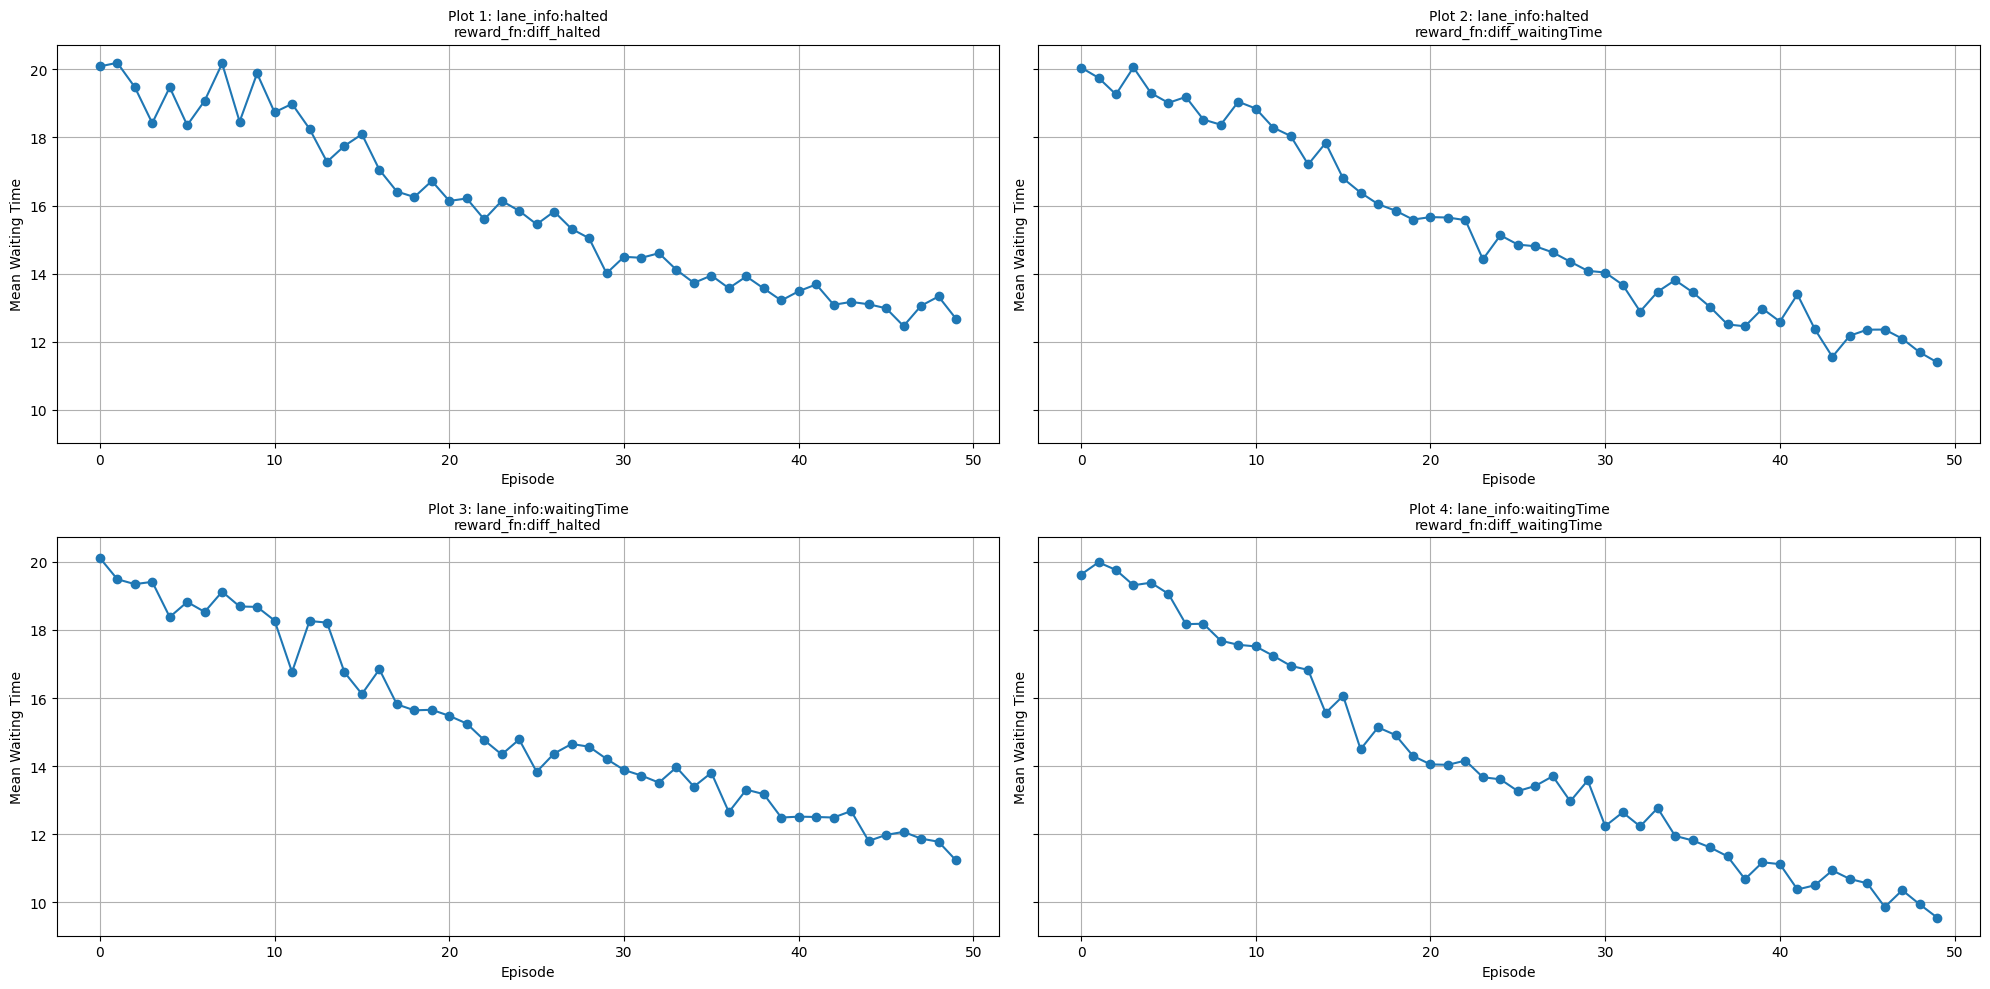

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(20,10), sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_params_1):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()
    

In [33]:
reward_fn = "diff_waitingTime"
lane_info = "waitingTime"

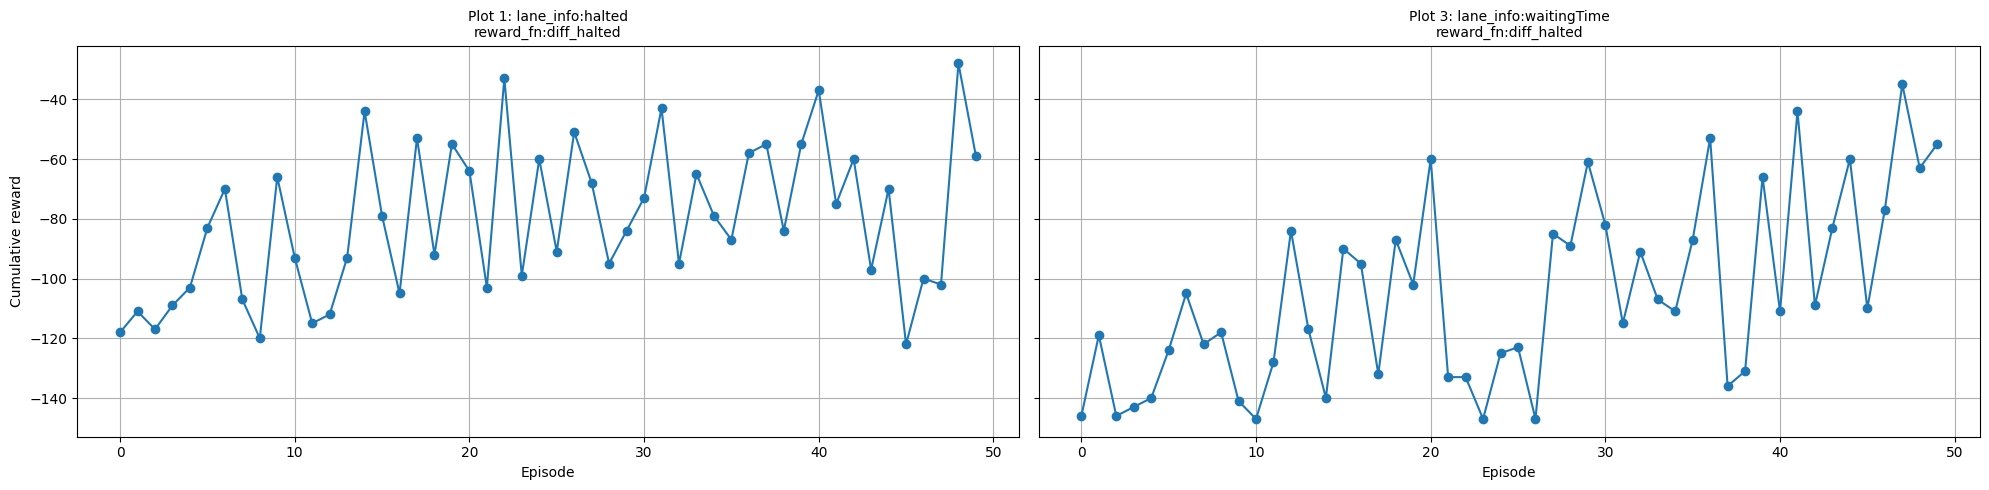

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)
axes = axes.flatten()

dfs = []
j = 0
for i, result in enumerate(results_params_1):
    if i%2 == 0:
        metrics = result['metrics']
        df = pd.DataFrame(metrics)
        axes[j].plot(df['episode'], df['cumulative_reward'], marker='o')
        axes[j].set_xlabel('Episode')
        if j == 0:
            axes[j].set_ylabel('Cumulative reward')
        title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
        axes[j].set_title(title, fontsize=10)
        axes[j].grid(True)
        j = j + 1
plt.tight_layout()
plt.show()

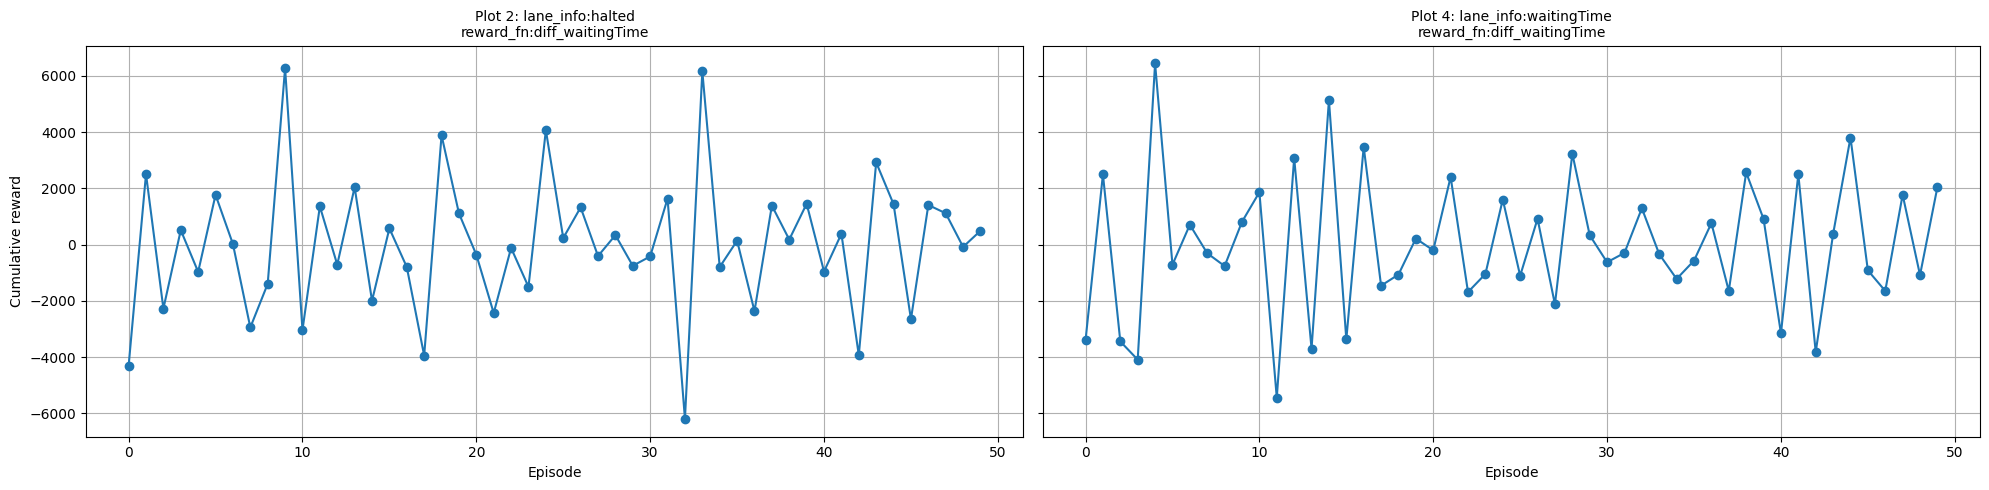

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), sharey=True)
axes = axes.flatten()

dfs = []
j = 0
for i, result in enumerate(results_params_1):
    if i%2 != 0:
        metrics = result['metrics']
        df = pd.DataFrame(metrics)
        axes[j].plot(df['episode'], df['cumulative_reward'], marker='o')
        axes[j].set_xlabel('Episode')
        if j == 0:
            axes[j].set_ylabel('Cumulative reward')
        title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
        axes[j].set_title(title, fontsize=10)
        axes[j].grid(True)
        j = j + 1
plt.tight_layout()
plt.show()

In [36]:
param_grid["encode_intervals"]

[8, 10, 14]

In [40]:
results_params_2 = []
for encode_interval in param_grid["encode_intervals"]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=50)
    params = "encode_interval:" + str(encode_interval)
    print("Learning with: " + params)
    metrics = agent.train();
    results_params_2.append({"params": params, "metrics": metrics })
    

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: encode_interval:8
 Retrying in 1 seconds
Learning with: encode_interval:10
 Retrying in 1 seconds
Learning with: encode_interval:14


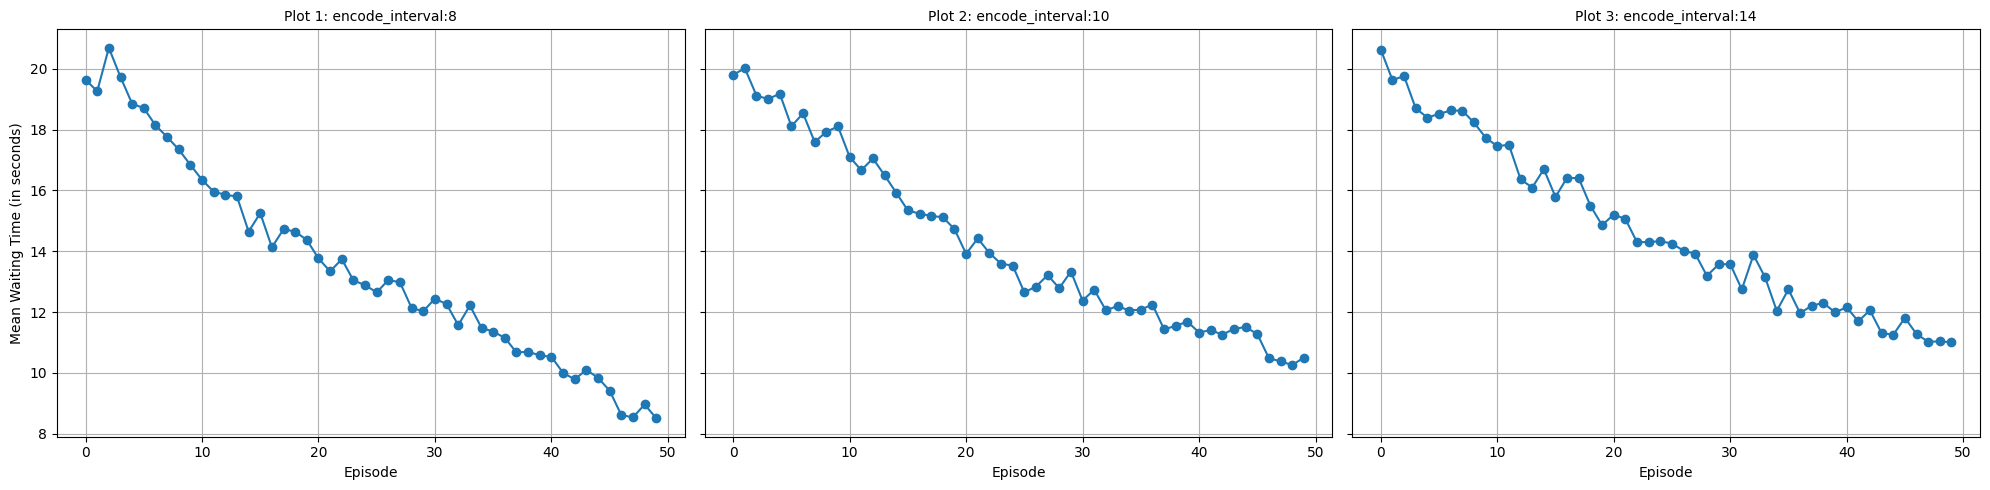

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(20,5),sharey=True)
axes = axes.flatten()


for i, result in enumerate(results_params_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

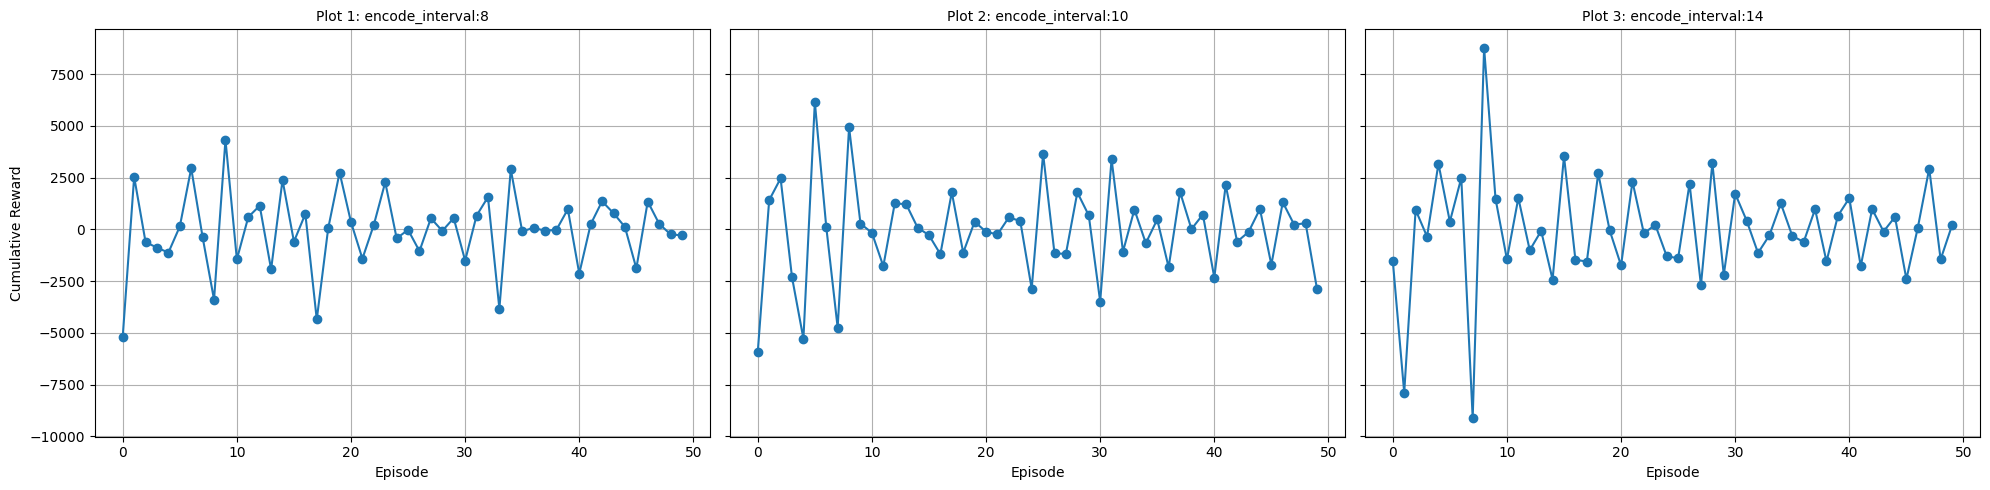

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20,5),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_params_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['cumulative_reward'], marker='o')
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Cumulative Reward')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [48]:
for encode_interval in [4, 6]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=50)
    params = "encode_interval:" + str(encode_interval)
    print("Learning with: " + params)
    metrics = agent.train();
    results_params_2.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: encode_interval:4
 Retrying in 1 seconds
Learning with: encode_interval:6


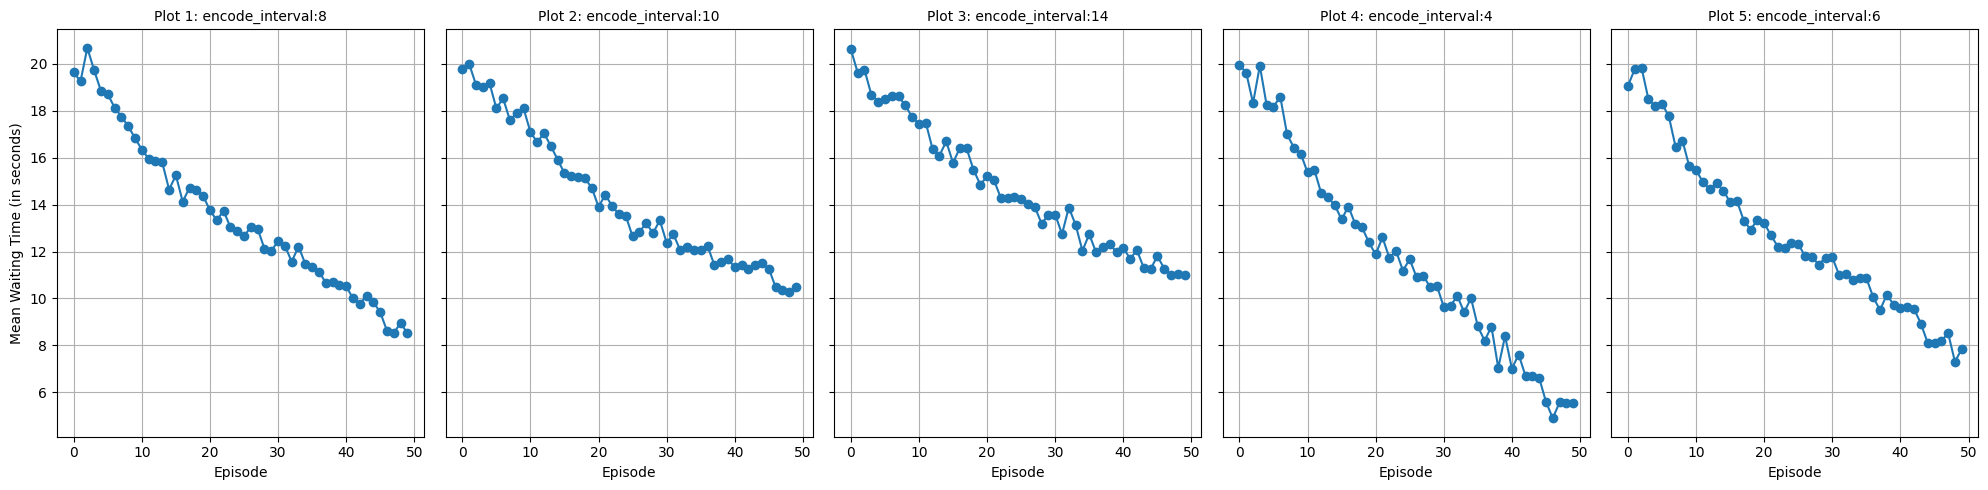

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(20,5),sharey=True)
axes = axes.flatten()


for i, result in enumerate(results_params_2):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [51]:
serializeResults(results_params_2, "results_params_2.csv")

In [52]:
results_params_2_plus = []
for encode_interval in [4,14]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=encode_interval, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=125)
    params = "encode_interval:" + str(encode_interval)
    print("Learning with: " + params)
    metrics = agent.train();
    results_params_2_plus.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: encode_interval:4
 Retrying in 1 seconds
Learning with: encode_interval:14


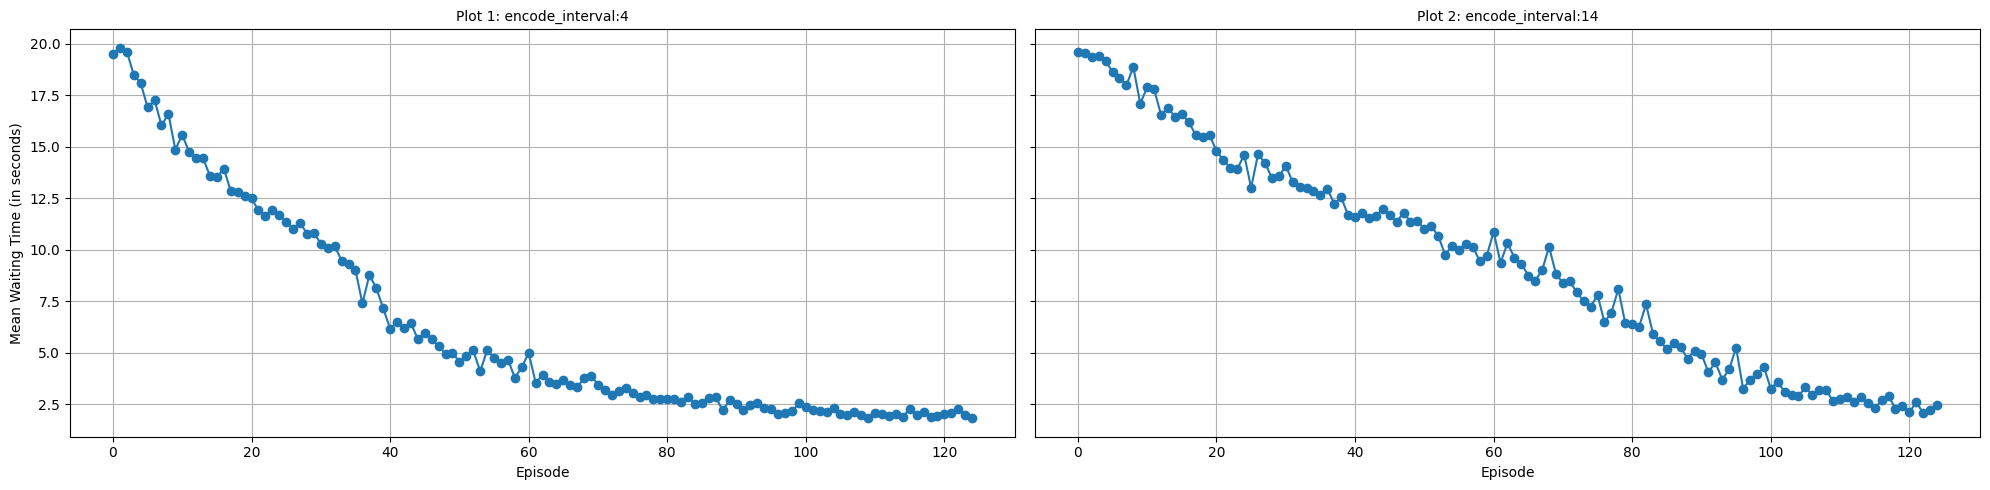

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(20,5),sharey=True)
axes = axes.flatten()


for i, result in enumerate(results_params_2_plus):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    
    axes[i].set_xlabel('Episode')
    if i == 0:
        axes[i].set_ylabel('Mean Waiting Time (in seconds)')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [58]:
serializeResults(results_params_2_plus, "results_params_2_plus.csv")

In [61]:
results_encInt14 = []
env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=14, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=1, endEpsilon=0.005, decayRate=0.025, episodes=200)
params = "encode_interval:" + str(14)
print("Learning with: " + params)
metrics = agent.train();
results_encInt14.append({"params": params, "metrics": metrics })

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: encode_interval:14


/tmp/ipykernel_4322/1412441770.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


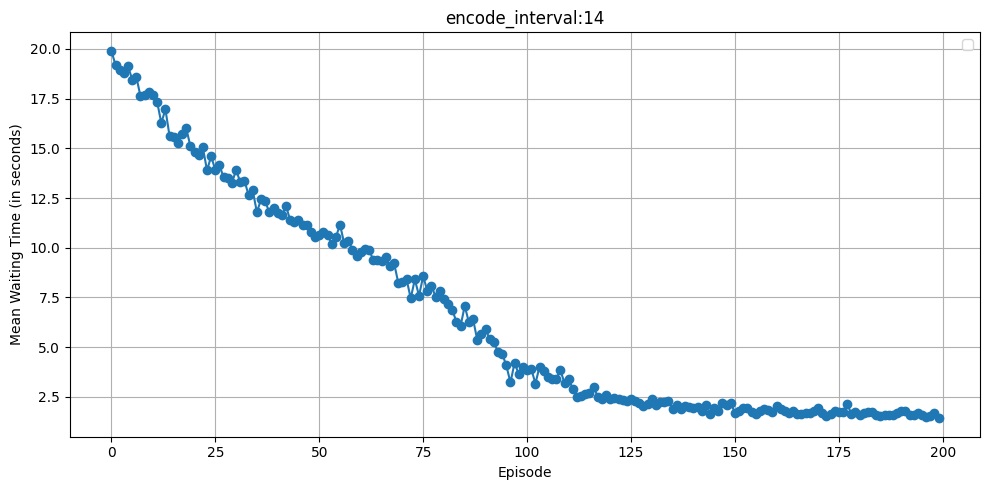

In [67]:
plt.figure(figsize=(10, 5))

metrics = results_encInt14[0]['metrics']
df = pd.DataFrame(metrics)
plt.plot(df['episode'], df['mean_waiting_time'], marker='o')

# Establecer etiquetas y título
plt.xlabel('Episode')
plt.ylabel('Mean Waiting Time (in seconds)')
plt.legend()
plt.grid(True)
plt.title(split_long_string(f"{result['params']}", 40))

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [68]:
serializeResults(results_encInt14, "results_encInt14.csv")

In [80]:
print("Tiempo de espera promedio en Episodio 50, con encode_interval=4", end=":\n\t")
print(results_params_2_plus[0]["metrics"][len(results_params_2_plus[0]["metrics"])-1]["mean_waiting_time"])
print("Tiempo de espera promedio en Episodio 200, con encode_interval=14", end=":\n\t")
print(results_encInt14[0]["metrics"][len(results_encInt14[0]["metrics"])-1]["mean_waiting_time"])

Tiempo de espera promedio en Episodio 50, con encode_interval=4:
	1.82034968487743
Tiempo de espera promedio en Episodio 200, con encode_interval=14:
	1.4175853049597538


Utilizar un valor alto de $encode\_interval$ (como 14) provoca que el agente aprenda una política de control de forma más lenta, resultando en una convergencia más tardía. Sin embargo, esto suele generar resultados ligeramente superiores en comparación a un $encode\_interval$ bajo (como 4).

Dado que la ejecución de un episodio en la simulación requiere un tiempo considerable, optamos por un valor intermedio de $encode\_interval$, específicamente 10.

In [81]:
encode_interval = 10

Sin embargo, para la exploración de los próximos parámetros utilizaremos $encode\_interval=4$

### Decay Rate & Starting Epsilon


In [94]:
results_epsilonGreedy_params = []

for start_epsilon in param_grid["start_epsilons"]:
    for decay_rate in param_grid["decay_rates"]:
        env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
        agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=0.1, startEpsilon=start_epsilon, endEpsilon=0.005, decayRate=decay_rate, episodes=100)
        params = "start_epsilon:" + str(start_epsilon)+",decay_rate:" + str(decay_rate)
        print("Learning with: " + params)
        metrics = agent.train()
        results_epsilonGreedy_params.append({"params": params, "metrics": metrics })
        
        

Connection 'default' is already active. Closing connection...
Connection 'default' is already active. Starting new connection...
 Retrying in 1 seconds
OK
Learning with: start_epsilon:1,decay_rate:0.02
 Retrying in 1 seconds
Learning with: start_epsilon:1,decay_rate:0.03
 Retrying in 1 seconds
Learning with: start_epsilon:0.8,decay_rate:0.02
 Retrying in 1 seconds
Learning with: start_epsilon:0.8,decay_rate:0.03


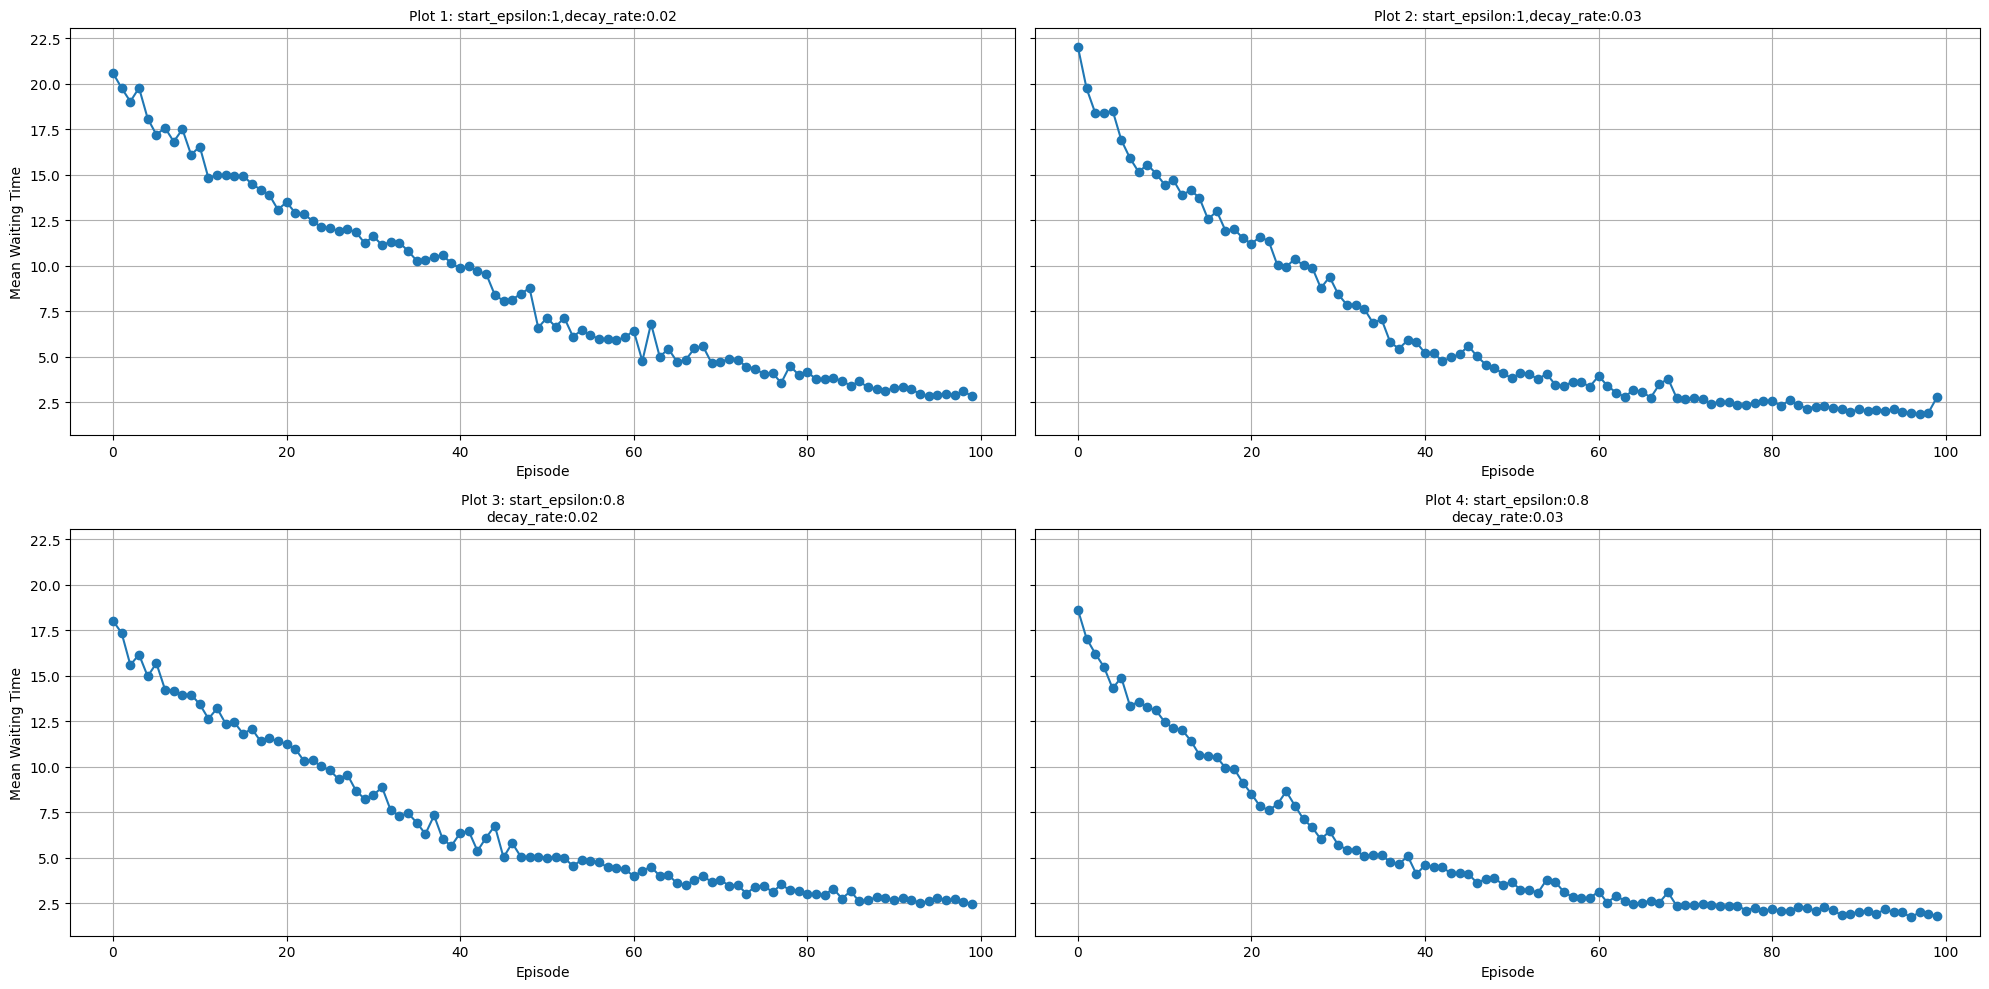

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(20,10),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_epsilonGreedy_params):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    if i%2 == 0:
        axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [100]:
serializeResults(results_epsilonGreedy_params, "results_epsilonGreedy_params.csv")

Como cabía esperar, un decay rate más alto, acorta la convergencia a una solución lo suficientemente buena. Adicionalmente la curva que determina la exploración del agente no sólo depende del decay rate, sino también de la cantidad de episodios de aprendizaje por refuerzo. Este parámetro se eligirá cuando se hayan explorado todos los demás parámetros y se realicen los entrenamientos finales para evaluar nuestro agente.

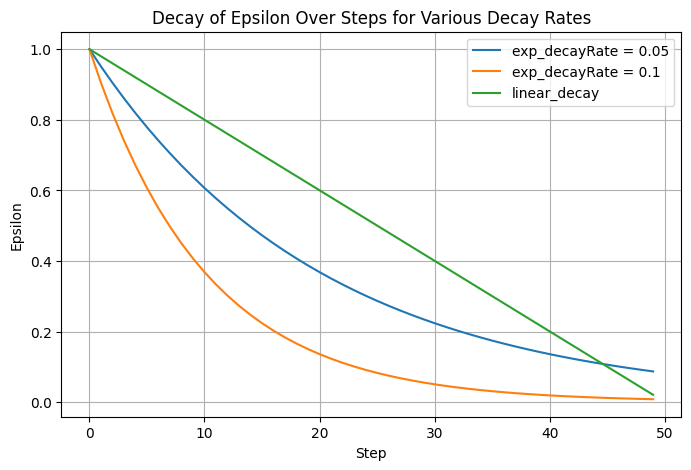

In [117]:
episodes = 50
endEpsilon = 0.01
startEpsilon = 1
plt.figure(figsize=(8, 5))
for decayRate in [0.05, 0.1]:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')
x, y = calculate_linear_epsilon(episodes)
plt.plot(x, y, label=f'linear_decay')
plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

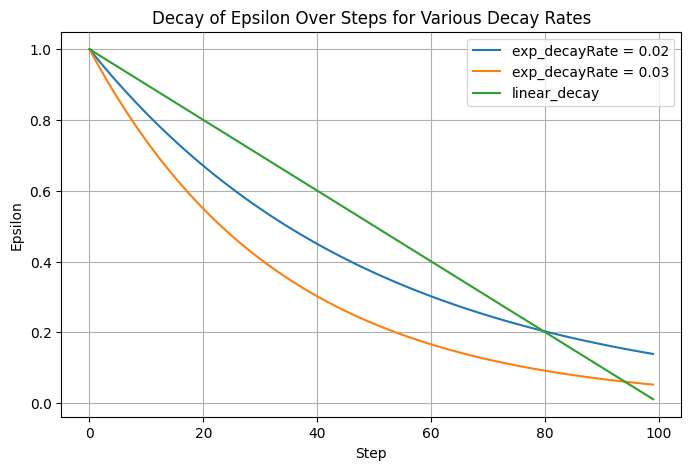

In [110]:
episodes = 100
endEpsilon = 0.01
startEpsilon = 1
plt.figure(figsize=(8, 5))
for decayRate in [0.02, 0.03]:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')
x, y = calculate_linear_epsilon(episodes)
plt.plot(x, y, label=f'linear_decay')
plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

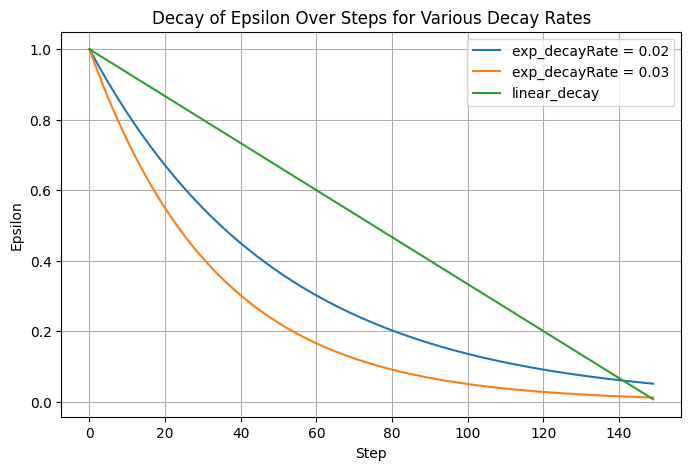

In [116]:
episodes = 150
endEpsilon = 0.01
startEpsilon = 1
plt.figure(figsize=(8, 5))
for decayRate in [0.02, 0.03]:
    x, y = calculate_exp_epsilon(decayRate, episodes)
    plt.plot(x, y, label=f'exp_decayRate = {decayRate}')
x, y = calculate_linear_epsilon(episodes)
plt.plot(x, y, label=f'linear_decay')
plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.title('Decay of Epsilon Over Steps for Various Decay Rates')
plt.legend()
plt.grid(True)
plt.show()

De forma arbitraria, durante lo queda de de la exploración de parémtros, se usaran varios decay rates dependiente de la cantidad de episodios.

In [118]:
decay_rate_100 = 0.02
decay_rate_50 = 0.05

En cuanto al epsilon inicial (start_epsilon), no hay observación clara con respecto a los dos valores usados (1 y 0.8). Solo la inherente al concepto de política epsilon-greedy. Un epsilon inicial de uno (1), hará que durante el primer episodio la exploración de acciones para cualquier estado sea completa. De forma arbitraria, escogemos $start\_epsilon=1$.

In [113]:
start_epsilon = 1

In [120]:
results_learning_rate = []

for learning_rate in param_grid["learning_rates"]:
    env = SumoEnvironment(sumocfgFile=sumoCfgFile_param_exploration, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=4, laneInfo=lane_info, rewardFn=reward_fn, fixedTL=False, simTime=43800, sumoLog=False)
    agent = ql_agent.QLAgent(environment=env, gamma=0.99, alpha=learning_rate, startEpsilon=start_epsilon, endEpsilon=0.005, decayRate=decay_rate_100, episodes=100)
    params = "learning_rate:" + str(learning_rate)
    print("Learning with: " + params)
    metrics = agent.train()
    results_learning_rate.append({"params": params, "metrics": metrics })

 Retrying in 1 seconds
Learning with: learning_rate:0.1
 Retrying in 1 seconds
Learning with: learning_rate:0.01
 Retrying in 1 seconds
Learning with: learning_rate:0.001


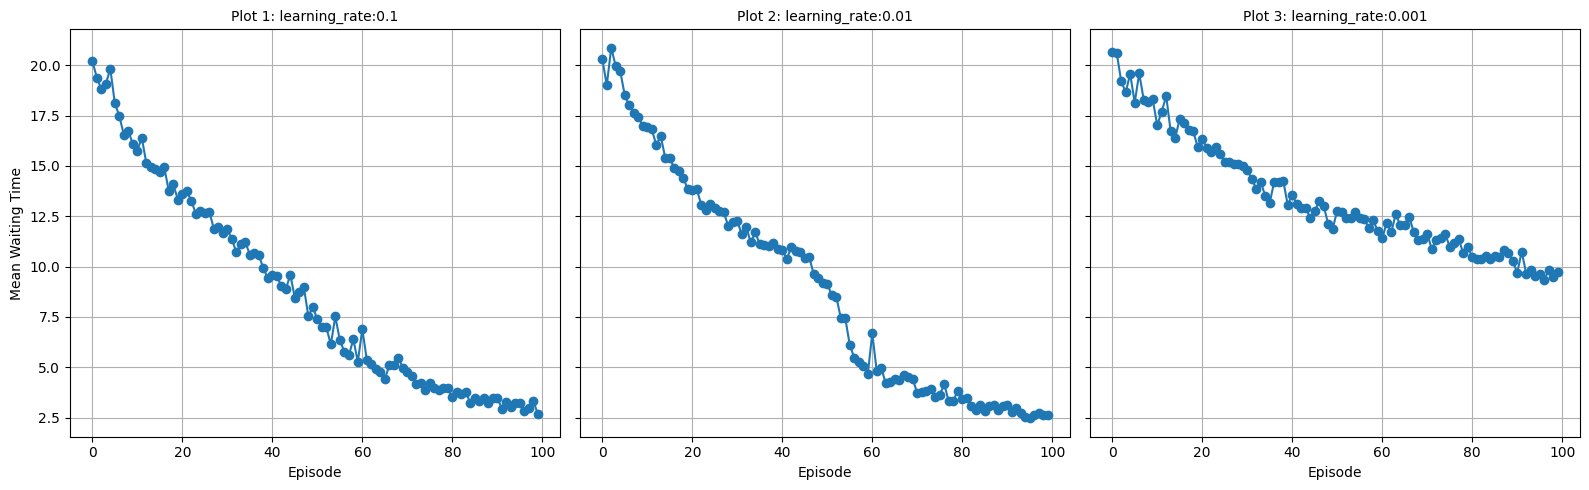

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(16,5),sharey=True)
axes = axes.flatten()

dfs = []
for i, result in enumerate(results_learning_rate):
    metrics = result['metrics']
    df = pd.DataFrame(metrics)
    axes[i].plot(df['episode'], df['mean_waiting_time'], marker='o')
    axes[i].set_xlabel('Episode')
    if i== 0:
        axes[i].set_ylabel('Mean Waiting Time')
    title = split_long_string(f"Plot {i+1}: {result['params']}", 40)
    axes[i].set_title(title, fontsize=10)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

In [121]:
serializeResults(results_learning_rate, "results_learning_rate.csv")

Al utilizar una tasa de aprendizaje 10 veces inferior a 0.01, el aprendizaje es muy lento. Por lo tanto utilizaremos un $learning\_rate = 0.01$

In [ ]:
Semáforos estaticos

In [ ]:
sumoCfgFile = os.path.abspath(os.path.join(current_dir, '../../nets/2x2_intersection/interseccion2.sumocfg'))

env = SumoEnvironment(sumocfgFile=sumoCfgFile, deltaTime=5, yellowTime=4, minGreenTime=10, gui=False, edges=False, discreteIntervals=6, laneInfo="waitingTime", rewardFn="diff_waitingTime", fixedTL=True)

agent = ftl_agent.FixedTLAgent(env, 5)

ftl_agent_metrics = agent.run();

df = pd.DataFrame(ftl_agent_metrics)
df

